# ANAC


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

#### Seed

In [17]:
seed = 2024
np.random.seed(seed)

In [18]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()
diet_matches_recipe_csv = pd.read_csv("DietMatchesRecipe.csv").copy()

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_17244\327035230.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [19]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df_whole = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
# merge whole df with own generated RecipeMatchesDiet
df = pd.merge(df_whole, diet_matches_recipe_csv, how="inner", on=["AuthorId", "RecipeId"])

### Data Cleaning

In [69]:
df

,AuthorId,RecipeId,Rating,Like,TestSetId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,...,RecipeYield,Diet,Age,Time,HighCalories,HighProtein,LowFat,LowSugar,HighFiber,DietMatchesRecipe
0,2492191A,33671,2.0,NaN,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,One dish meal,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...",...,NaN,Omnivore,19,2698.714376,0.0,Indifferent,1,0,1,True
1,2002019979A,92647,2.0,NaN,2.0,Pork and Chickpea Chili,1200,1200,Other,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...",...,NaN,Omnivore,66,2399.694583,1.0,Indifferent,0,Indifferent,1,True
2,408594E,161770,NaN,NaN,3.0,Stuffed Zucchini With Sausage,1200,900,Other,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...",...,NaN,Omnivore,35,2099.113170,1.0,Indifferent,0,0,1,True
3,2001625557E,108231,2.0,NaN,4.0,Cream Cheese and Beef Cracker Spread,0,1200,Other,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")",...,2 cups,Omnivore,76,1199.645575,1.0,Yes,0,0,1,True
4,2001427116E,71109,NaN,NaN,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,Other,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...",...,4 Breast halves,Omnivore,56,2341.181827,1.0,Indifferent,0,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,2.0,False,NaN,Pumpkin Cake Mix Dessert,3000,900,Other,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...",...,NaN,Vegetarian,31,3899.421310,0.0,Indifferent,1,Indifferent,0,True
140191,999774A,29002,2.0,False,NaN,Summer Corkscrew Pasta,1200,1200,Other,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...",...,NaN,Vegetarian,57,2402.372535,0.0,Indifferent,0,Indifferent,0,False
140192,999774A,159252,NaN,False,NaN,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,Other,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")",...,4 cups,Vegetarian,57,5999.598903,0.0,Yes,0,0,0,True
140193,999774A,1171,2.0,True,NaN,Kahlua Hot Chocolate,360,120,Beverages,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...",...,2 mugs,Vegetarian,57,480.233207,1.0,Yes,0,0,0,True


#### Basics

In [20]:
# Rename AuthorId column
df = df.dropna(subset=['Diet'])
df.rename(columns= {"AuthorId" : "CustomerId"}, inplace=True)

# Change types of Diet & RecipeCategory into category
df["Diet"] = df["Diet"].astype("category")
df["RecipeCategory"] = df["RecipeCategory"].astype("category")

# Change types to boolean
df["HighCalories"] = df["HighCalories"].astype("category")
df["LowFat"] = df["LowFat"].astype("category")
df["HighFiber"] = df["HighFiber"].astype("category")
df["Like"] = df["Like"].astype("bool")

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)

# Map indifferent values for HighProtein and LowSugar
mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No', '0': 'No', '1': 'Yes'}
df["HighProtein"] = df["HighProtein"].map(mapping_protein).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No', }
df["LowSugar"] = df["LowSugar"].map(mapping_sugar).astype('category')

# One hot encoding for categorical variables
df["DifferenceRequestedAndTimeNeeded"] = df["Time"] - (df["CookTime"] + df["PrepTime"])
df = pd.get_dummies(df, columns=["Diet", "RecipeCategory", "HighProtein", "LowSugar", "LowFat", "HighFiber", "HighCalories"], drop_first=True)

***Split data***

In [21]:
# Split data into train and test set

train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

### Missing values

In [22]:
train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_17244\3079801577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(subset=["Like"], inplace=True)


In [23]:
train_set = train_set[train_set["Calories"] < 300000]

In [24]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)
test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)

C:\Users\Maximilian Mittmann\AppData\Local\Temp\ipykernel_17244\2659033877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['RecipeServings'].fillna(recipesServings_mean, inplace=True)


***Train Model***


In [168]:
train_set

,CustomerId,RecipeId,Like,Name,CookTime,PrepTime,RecipeIngredientQuantities,RecipeIngredientParts,Calories,FatContent,...,Diet_Vegan,Diet_Vegetarian,RecipeCategory_Bread,RecipeCategory_Breakfast,RecipeCategory_Lunch,RecipeCategory_One dish meal,RecipeCategory_Other,RecipeCategory_Soup,HighProtein_Yes,LowSugar_No
42814,1000036C,320576,False,Downeaster,0,120,"""2""","c(""\""vodka\"""", ""\""cranberry juice\"""", ""\""lime ...",138.7,0.0,...,False,True,False,False,False,False,False,False,False,False
42815,1000216B,189335,False,Thai Rice Soup (Kao Tome Gai),600,600,"c(""\""6\"""", ""\""4\"""", ""\""8\"""", ""\""4\"""", ""\""1/2\""...","c(""\""garlic\"""", ""\""cooked rice\"""", ""\""ground c...",395.7,19.2,...,False,True,False,False,False,False,True,False,True,True
42816,1000221A,133043,False,Lemon and Thyme Marinade for Poultry,60,300,"c(""\""4\"""", ""\""4\"""", ""\""4\"""")","c(""\""lemon juice\"""", ""\""fresh thyme\"""", ""\""dri...",125.6,13.5,...,False,True,False,False,False,False,True,False,True,False
42817,1000221A,90537,False,Black Bean Salsa,0,1200,"c(""\""2\"""", ""\""1\"""", ""\""1/2\"""", ""\""1\"""", ""\""1\""...","c(""\""black beans\"""", ""\""frozen corn\"""", ""\""gre...",1590.1,49.0,...,False,True,False,True,False,False,False,False,True,True
42818,1000221A,334314,False,Irish Soda Bread,3600,1800,"c(""\""3\"""", ""\""2/3\"""", ""\""3\"""", ""\""1\"""", ""\""1/2...","c(""\""flour\"""", ""\""sugar\"""", ""\""baking powder\""...",770.9,11.0,...,False,True,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140190,999595E,338070,False,Pumpkin Cake Mix Dessert,3000,900,"c(""\""1\"""", ""\""1\"""", ""\""1\"""", ""\""3\"""", ""\""1\"""",...","c(""\""pumpkin puree\"""", ""\""evaporated milk\"""", ...",464.3,31.4,...,False,True,False,False,False,False,True,False,False,False
140191,999774A,29002,False,Summer Corkscrew Pasta,1200,1200,"c(""\""1\"""", ""\""8 -10\"""", ""\""3\"""", ""\""1/3\"""", ""\...","c(""\""corkscrew macaroni\"""", ""\""zucchini\"""", ""\...",838.5,33.3,...,False,True,False,False,False,False,True,False,False,False
140192,999774A,159252,False,"Chili, Kaffir Lime and Lemongrass Jelly",4800,1200,"c(""\""12\"""", ""\""5\"""", ""\""2\"""", ""\""2\"""", ""\""4\"""")","c(""\""kaffir lime leaves\"""", ""\""apples\"""", ""\""l...",928.0,0.6,...,False,True,False,False,False,False,True,False,True,True
140193,999774A,1171,True,Kahlua Hot Chocolate,360,120,"c(""\""2\"""", ""\""1/4\"""", ""\""2\"""", ""\""1/4\"""", ""\""2...","c(""\""sugar\"""", ""\""ground cinnamon\"""", ""\""groun...",665.9,19.8,...,False,True,False,False,False,False,False,False,True,True


In [25]:
#Variables that are good according to xgboost: 

#variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', "Calories", "SaturatedFatContent", "SugarContent", "CookTime", "PrepTime", "Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Other", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_Soup", "RecipeCategory_One dish meal", "LowSugar_No", "CholesterolContent", "SodiumContent", "FiberContent", "RecipeServings", "Time", "HighCalories", "HighFiber"]

variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield',"Time"]
X = train_set.drop(variables_to_drop, axis=1)
y = train_set['Like']
test_set = test_set.drop(variables_to_drop, axis=1)

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saled_df = scaler.fit_transform(X)
saled_df

array([[0.00000000e+00, 6.94444444e-06, 3.04106646e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.78703704e-05, 3.47222222e-05, 8.67591923e-03, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.78703704e-06, 1.73611111e-05, 2.75384244e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [4.62962963e-04, 6.94444444e-05, 2.03468614e-02, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.47222222e-05, 6.94444444e-06, 1.46001886e-02, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.60416667e-04, 5.20833333e-05, 4.27108685e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [114]:
transform_scaler = StandardScaler()

scaled_df = transform_scaler.fit_transform(saled_df)
scaled_df

array([[-0.04894695, -0.03817755, -0.45347737, ..., -0.04758473,
        -0.81339081, -1.52558535],
       [-0.04369983, -0.03150394, -0.1134095 , ..., -0.04758473,
         1.22942131,  0.65548611],
       [-0.04842224, -0.03567495, -0.47081157, ..., -0.04758473,
         1.22942131, -1.52558535],
       ...,
       [-0.00696998, -0.02316193,  0.59094117, ..., -0.04758473,
         1.22942131,  0.65548611],
       [-0.04579868, -0.03817755,  0.24412488, ..., -0.04758473,
         1.22942131,  0.65548611],
       [-0.02533491, -0.02733294, -0.37924466, ..., -0.04758473,
        -0.81339081, -1.52558535]])

In [26]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=seed)

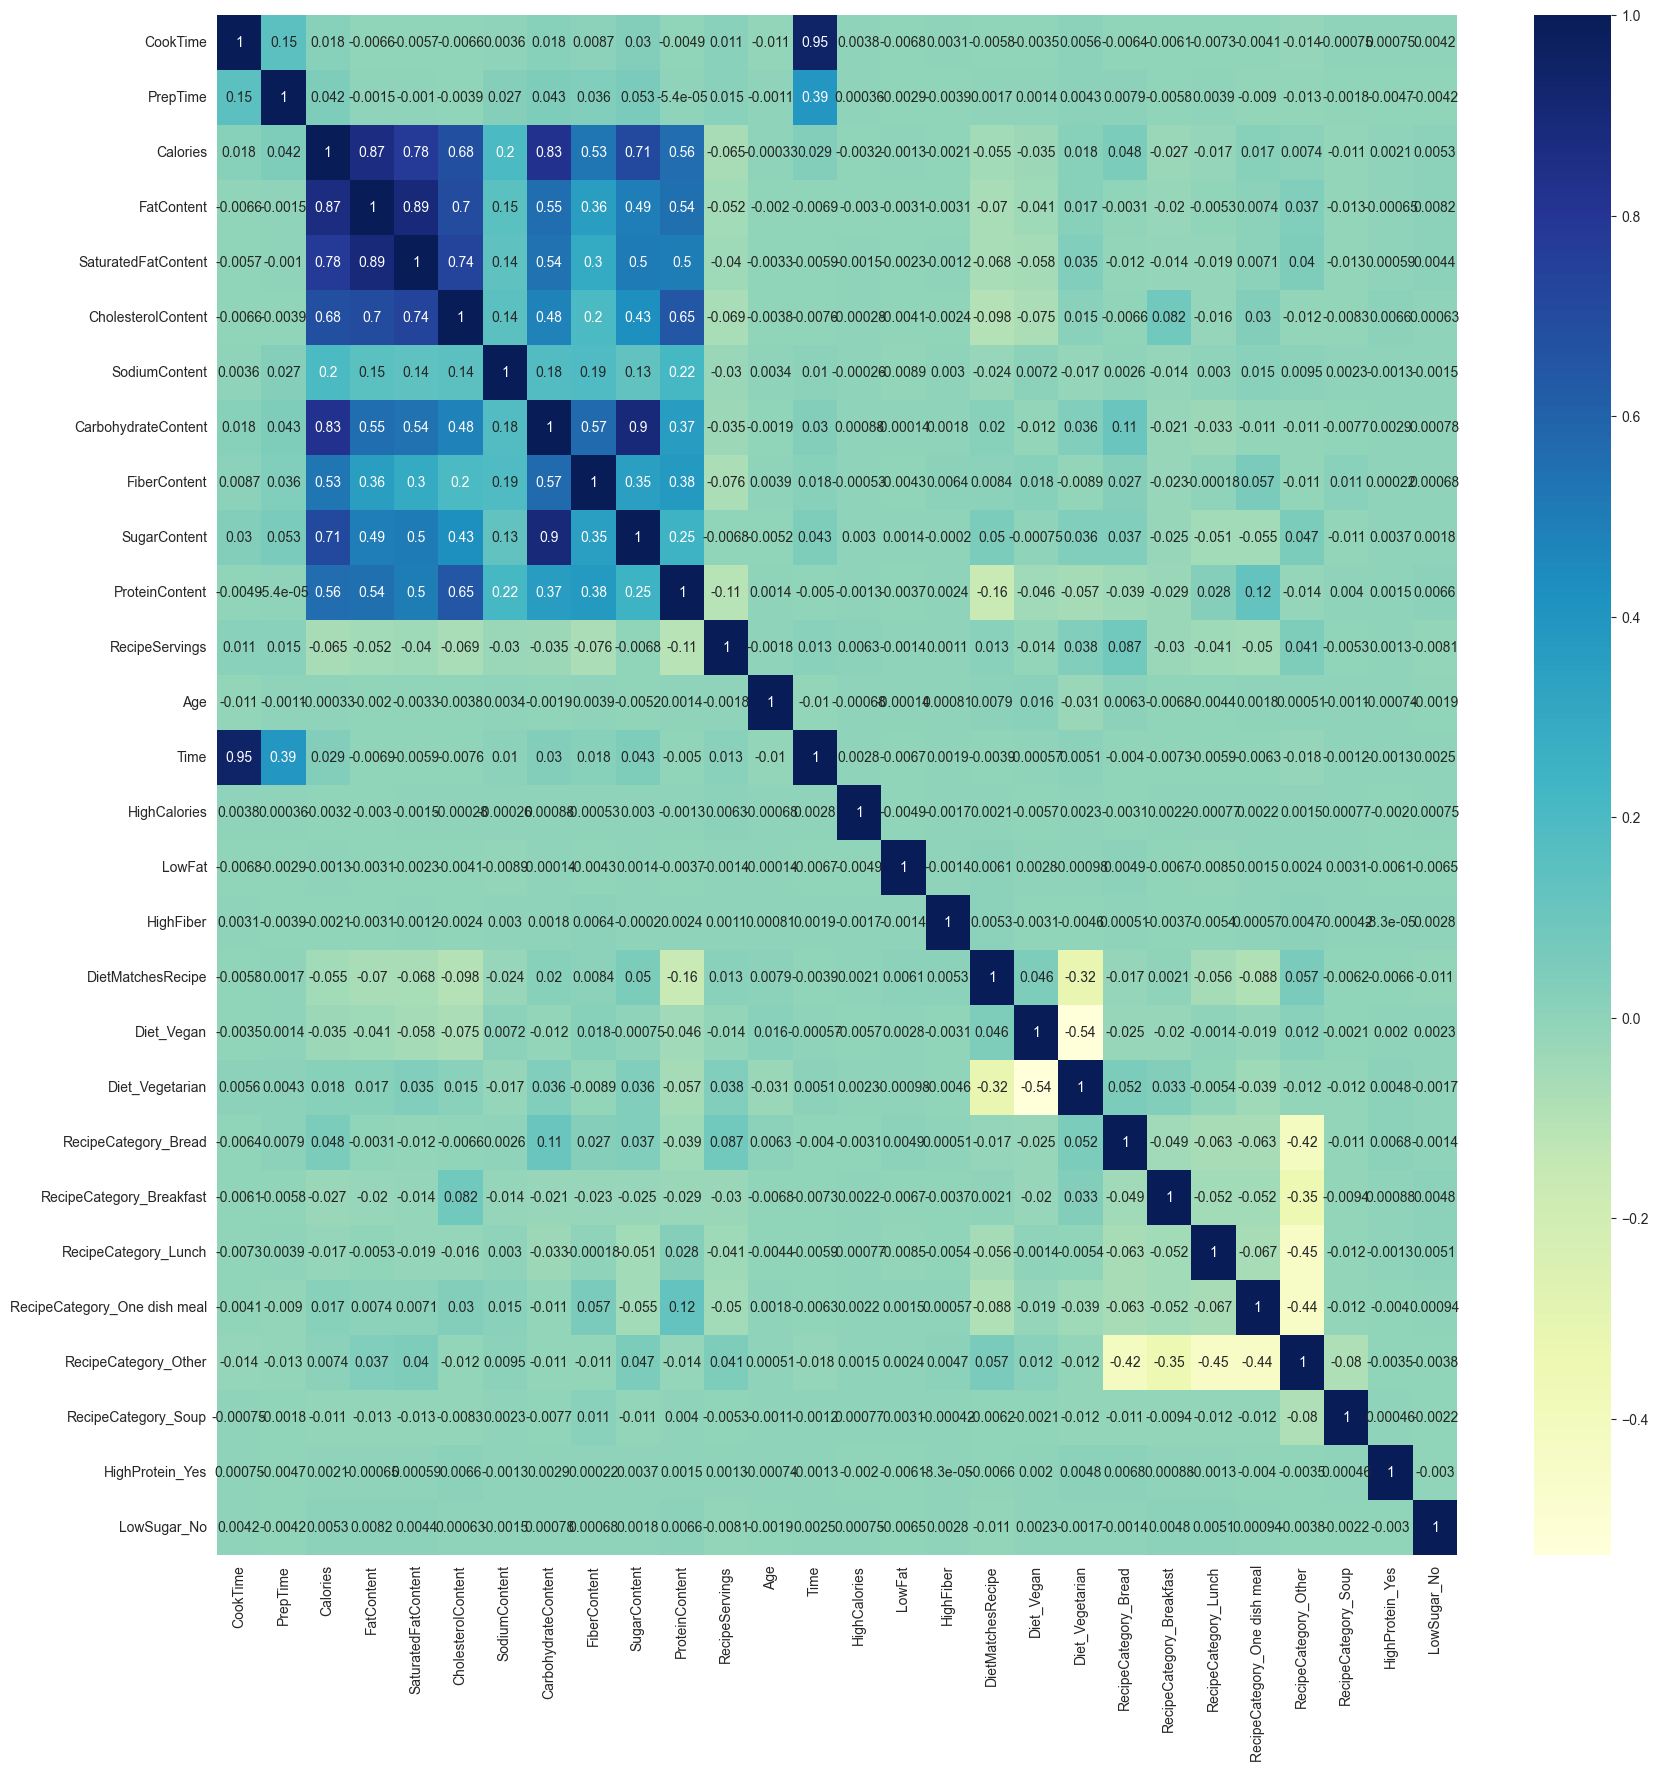

In [66]:
import seaborn as sns
plt.figure(figsize=(20,20))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")
plt.show()

In [181]:
def correlation(df, threshhold):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j] > threshhold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.7)
corr_features

set()

In [44]:
# Grid Search
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [ 200, 250, 300, 350, 400],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 5, 7, 10],
    # Add other hyperparameters
}

gbc = GradientBoostingClassifier(random_state=seed)

random_search = RandomizedSearchCV(
    gbc, param_distributions=param_grid, n_iter=10, scoring='balanced_accuracy', cv=5, n_jobs=-1
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingClassifier(random_state=2024),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [200, 250, 300, 350,
                                                         400]},
                   scoring='balanced_accuracy')

In [45]:
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_
results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv("grid_search_results_csv", index=False)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Best Model:", best_model)

# Display the full results DataFrame
print("Full Results:")
print(results_df)

Best Parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.3}
Best Score: 0.7201009829127327
Best Model: GradientBoostingClassifier(learning_rate=0.3, max_depth=7, n_estimators=400,
                           random_state=2024)
Full Results:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     221.868448      5.015677         0.139327        0.005158   
1     180.584014      2.228736         0.118708        0.003724   
2      70.668419      0.504373         0.058253        0.001601   
3     142.985541      3.414366         0.098690        0.002872   
4     147.932650      3.734415         0.097089        0.001266   
5     122.518684      2.137260         0.080473        0.001201   
6     252.975805      5.128420         0.160747        0.003203   
7     286.698346      4.478556         0.177362        0.006052   
8     170.861352      4.563197         0.106097        0.010344   
9     133.216036      4.087018         0.082275        0.003766   

  par

In [27]:
# Gradient Boosting

train_model = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=7, random_state=seed)

train_model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=7, n_estimators=400, random_state=2024)

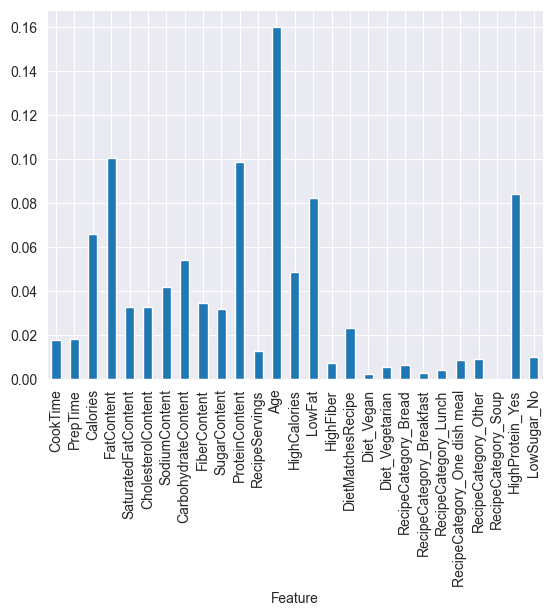

In [117]:
# Plot feature importance 
importance_values = train_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_values})
imp_plot = importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
imp_plot.plot()
plt.show()

In [28]:
test_predictions = train_model.predict(X_test)
test_probabilities = train_model.predict_proba(X_test)

test_predictions_df = pd.DataFrame({'Like': y_test, 
                                     'Predicted_Like': test_predictions,
                                     'Probability_Like=0': test_probabilities[:, 0],
                                     'Probability_Like=1': test_probabilities[:, 1]})
print(test_predictions_df)


# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Precision, accuracy, recall
print("Test-Precision:", precision_score(y_test, test_predictions))
print("Test-Accuracy:", accuracy_score(y_test, test_predictions))
print("Test-Recall:", recall_score(y_test, test_predictions))
print("Test Balanced Accuracy:", balanced_accuracy_score(y_test, test_predictions))

         Like  Predicted_Like  Probability_Like=0  Probability_Like=1
57595   False           False            0.943018            0.056982
45723   False           False            0.988917            0.011083
86478   False           False            0.994591            0.005409
133143  False           False            0.997373            0.002627
65385   False           False            0.999353            0.000647
...       ...             ...                 ...                 ...
80133   False           False            0.991412            0.008588
58468   False           False            0.715777            0.284223
86921   False           False            0.999449            0.000551
95676   False           False            0.505085            0.494915
115763  False           False            0.993502            0.006498

[29214 rows x 4 columns]
Confusion Matrix:
[[24496   823]
 [ 2059  1836]]
Test-Precision: 0.6904851447912749
Test-Accuracy: 0.9013486684466352
Test-Recall: 0.4

0.7204

***Output file with test set***

In [352]:
test_set["prediction"] = train_model.predict(test_set.drop("TestSetId", axis=1))
test_output = pd.DataFrame(columns=["TestSetId", "prediction"])
test_output["TestSetId"] = test_set["TestSetId"].astype(int)
test_output["prediction"] = test_set["prediction"].astype(int)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_1.csv", index=False)

c:\users\maximilian mittmann\pycharmprojects\analyticscuptumforrest\venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
